In [22]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from typing import TypedDict
from dotenv import load_dotenv

load_dotenv()

True

In [23]:
# openAi model 
model = ChatOpenAI(
    model='openai/gpt-oss-20b',
    base_url="https://api.groq.com/openai/v1",
)

In [37]:
# Prompt templete

prompt = PromptTemplate(
    template = """
You are a brutally honest roast comedian AI.

You will be given:
- A BMI score 
- A BMI categor

Your job is to roast the BMI result aggressively using sharp sarcasm,
dark humor, and exaggerated metaphors.

Rules:
- Roast the BMI and the category, NOT the person.
- No personal insults, no hate speech.
- No medical advice.
- No apologies.
- Be funny, ruthless, and confident.

BMI Score: {bmi}
BMI Category: {category}

Deliver a savage roast in 3–5 lines.
End with a darkly motivational punchline.
""",
input_variables=["bmi", "category"]
)

In [25]:
# create State
class BMIState(TypedDict):
    weight_kg: float
    height_m: float
    bmi_result: float
    category: str
    bmi_roast: str

In [33]:
# Nodes

# Node-1
def calculate_bmi(state: BMIState) -> BMIState:

    weight = state['weight_kg']
    height = state['height_m']

    bmi_result = weight / (height**2)

    state['bmi_result'] = round(bmi_result,2)

    return state

# Node-2

def label_bmi(state: BMIState) -> BMIState:

    bmi = state['bmi_result']

    if bmi < 18.5:
        state['category'] = 'UnderWeight'
    elif 18.5 <= bmi < 25:
        state['category'] = 'Normal'
    elif 25 <= bmi < 30:
        state['category'] = 'OverWeight'
    else:
        state['category'] = 'Obese'

    return state

# Node-3
def roast_my_bmi(state: BMIState) -> BMIState:
    bmi = state["bmi_result"]
    category = state["category"]

    chain = prompt | model

    response = chain.invoke({
        "bmi": bmi,
        "category": category
    })

    state["bmi_roast"] = response.content
    return state

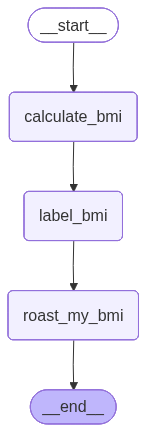

In [34]:
# define Graph 
graph = StateGraph(BMIState) 

# 1-> add nodes to our graph
graph.add_node('calculate_bmi', calculate_bmi)
graph.add_node('label_bmi', label_bmi)
graph.add_node('roast_my_bmi',roast_my_bmi)

# 2-> add egdes between nodes
graph.add_edge(START, 'calculate_bmi')
graph.add_edge('calculate_bmi', 'label_bmi')
graph.add_edge('label_bmi', 'roast_my_bmi')
graph.add_edge('roast_my_bmi', END)
 
# 3-> compile the graph
workflow = graph.compile()
graph.compile()

In [38]:
# 4-> excute the graph
intial_state = {'weight_kg':10, 'height_m': 1.0}
final_state = workflow.invoke(intial_state)

print("Your Bmi is: ",final_state['bmi_result'])
print("Your Category is: ",final_state['category'])
print("------This is Your BMI_ROAST------\n",final_state['bmi_roast'])

Your Bmi is:  10.0
Your Category is:  UnderWeight
------This is Your BMI_ROAST------
 Score 10.0—if BMI were a talent show, that number would be the “I’m still learning to count” contestant.  
UnderWeight? It’s the label that says your body is lighter than a polite apology after a bad joke.  
The chart apparently took a day off, leaving you to wonder if it’s measuring mass or how much ego you’re carrying.  
So if your mission is to be a walking definition of “lightweight,” you’re crushing it.  
Darkly motivational: “Aim to be so light you can outshine your own shadow—just don’t forget to leave something for the world to lift.”
